<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[03:09:19] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


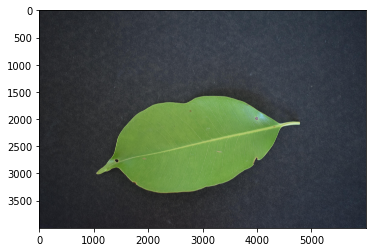

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

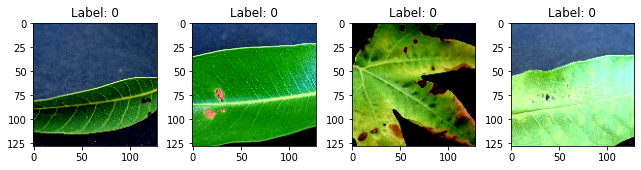

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[03:09:25] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[03:09:27] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.256769534866422 samples/sec                   batch loss = 0.6123873591423035 | accuracy = 0.5


Epoch[1] Batch[10] Speed: 1.265745587129924 samples/sec                   batch loss = 0.476592481136322 | accuracy = 0.625


Epoch[1] Batch[15] Speed: 1.268299925446666 samples/sec                   batch loss = 0.6568013429641724 | accuracy = 0.65


Epoch[1] Batch[20] Speed: 1.2280550119400224 samples/sec                   batch loss = 0.5622159838676453 | accuracy = 0.6875


Epoch[1] Batch[25] Speed: 1.2642592622734883 samples/sec                   batch loss = 0.8100084662437439 | accuracy = 0.69


Epoch[1] Batch[30] Speed: 1.2644542130571512 samples/sec                   batch loss = 0.4604078531265259 | accuracy = 0.675


Epoch[1] Batch[35] Speed: 1.265142452436927 samples/sec                   batch loss = 0.7066494822502136 | accuracy = 0.6642857142857143


Epoch[1] Batch[40] Speed: 1.273825340802924 samples/sec                   batch loss = 0.6923586130142212 | accuracy = 0.64375


Epoch[1] Batch[45] Speed: 1.2648298962524138 samples/sec                   batch loss = 0.7729812860488892 | accuracy = 0.6055555555555555


Epoch[1] Batch[50] Speed: 1.2663223429311032 samples/sec                   batch loss = 0.4719030261039734 | accuracy = 0.61


Epoch[1] Batch[55] Speed: 1.2677065197071913 samples/sec                   batch loss = 0.37028801441192627 | accuracy = 0.6363636363636364


Epoch[1] Batch[60] Speed: 1.2669799904016759 samples/sec                   batch loss = 0.3365309536457062 | accuracy = 0.6458333333333334


Epoch[1] Batch[65] Speed: 1.2662455965568706 samples/sec                   batch loss = 1.2773700952529907 | accuracy = 0.6461538461538462


Epoch[1] Batch[70] Speed: 1.2637729097791353 samples/sec                   batch loss = 0.6815872192382812 | accuracy = 0.625


Epoch[1] Batch[75] Speed: 1.2686080599015448 samples/sec                   batch loss = 0.5613348484039307 | accuracy = 0.6266666666666667


Epoch[1] Batch[80] Speed: 1.2727432312089586 samples/sec                   batch loss = 0.3907437324523926 | accuracy = 0.625


Epoch[1] Batch[85] Speed: 1.266772973451719 samples/sec                   batch loss = 0.5780956149101257 | accuracy = 0.6176470588235294


Epoch[1] Batch[90] Speed: 1.267756427960708 samples/sec                   batch loss = 0.5600512623786926 | accuracy = 0.6194444444444445


Epoch[1] Batch[95] Speed: 1.2654639445474911 samples/sec                   batch loss = 0.7765356302261353 | accuracy = 0.6210526315789474


Epoch[1] Batch[100] Speed: 1.2714254058702616 samples/sec                   batch loss = 0.22409754991531372 | accuracy = 0.625


Epoch[1] Batch[105] Speed: 1.2730174016514337 samples/sec                   batch loss = 0.6652116775512695 | accuracy = 0.6261904761904762


Epoch[1] Batch[110] Speed: 1.2743043634925197 samples/sec                   batch loss = 0.8591867685317993 | accuracy = 0.615909090909091


Epoch[1] Batch[115] Speed: 1.2727061562849686 samples/sec                   batch loss = 0.3902773857116699 | accuracy = 0.6086956521739131


Epoch[1] Batch[120] Speed: 1.2726530579425552 samples/sec                   batch loss = 0.35223695635795593 | accuracy = 0.6125


Epoch[1] Batch[125] Speed: 1.2720810354547174 samples/sec                   batch loss = 0.8624741435050964 | accuracy = 0.616


Epoch[1] Batch[130] Speed: 1.2704349061372946 samples/sec                   batch loss = 0.5534255504608154 | accuracy = 0.6192307692307693


Epoch[1] Batch[135] Speed: 1.2684764634753871 samples/sec                   batch loss = 1.3115880489349365 | accuracy = 0.6148148148148148


Epoch[1] Batch[140] Speed: 1.2693406837176942 samples/sec                   batch loss = 0.5492507219314575 | accuracy = 0.6125


Epoch[1] Batch[145] Speed: 1.2673403267682066 samples/sec                   batch loss = 0.1340070366859436 | accuracy = 0.6155172413793103


Epoch[1] Batch[150] Speed: 1.2741595834523152 samples/sec                   batch loss = 1.4109256267547607 | accuracy = 0.61


Epoch[1] Batch[155] Speed: 1.2741284252060474 samples/sec                   batch loss = 0.3891993463039398 | accuracy = 0.6129032258064516


Epoch[1] Batch[160] Speed: 1.268464954882257 samples/sec                   batch loss = 0.26627951860427856 | accuracy = 0.6125


Epoch[1] Batch[165] Speed: 1.2706426406184619 samples/sec                   batch loss = 0.99302077293396 | accuracy = 0.6151515151515151


Epoch[1] Batch[170] Speed: 1.2726564367959783 samples/sec                   batch loss = 0.44423890113830566 | accuracy = 0.6176470588235294


Epoch[1] Batch[175] Speed: 1.2680104365959863 samples/sec                   batch loss = 0.4676980674266815 | accuracy = 0.6185714285714285


Epoch[1] Batch[180] Speed: 1.2768155593387769 samples/sec                   batch loss = 0.8906818628311157 | accuracy = 0.6208333333333333


Epoch[1] Batch[185] Speed: 1.2673048104162246 samples/sec                   batch loss = 0.6542672514915466 | accuracy = 0.6202702702702703


Epoch[1] Batch[190] Speed: 1.2635926344878095 samples/sec                   batch loss = 0.6794430017471313 | accuracy = 0.6197368421052631


Epoch[1] Batch[195] Speed: 1.2714217444951867 samples/sec                   batch loss = 1.0089629888534546 | accuracy = 0.6230769230769231


Epoch[1] Batch[200] Speed: 1.2701551156112447 samples/sec                   batch loss = 0.980740487575531 | accuracy = 0.62625


Epoch[1] Batch[205] Speed: 1.2698795813606754 samples/sec                   batch loss = 0.5261853933334351 | accuracy = 0.6292682926829268


Epoch[1] Batch[210] Speed: 1.2731692650560553 samples/sec                   batch loss = 0.3540179431438446 | accuracy = 0.6273809523809524


Epoch[1] Batch[215] Speed: 1.2766197899010836 samples/sec                   batch loss = 1.0705578327178955 | accuracy = 0.6302325581395349


Epoch[1] Batch[220] Speed: 1.2808420574958375 samples/sec                   batch loss = 0.8760868906974792 | accuracy = 0.6329545454545454


Epoch[1] Batch[225] Speed: 1.274628786334563 samples/sec                   batch loss = 0.7249804735183716 | accuracy = 0.6333333333333333


Epoch[1] Batch[230] Speed: 1.2731484927950831 samples/sec                   batch loss = 2.3231284618377686 | accuracy = 0.6347826086956522


Epoch[1] Batch[235] Speed: 1.2720317505712582 samples/sec                   batch loss = 0.5492278337478638 | accuracy = 0.6340425531914894


Epoch[1] Batch[240] Speed: 1.2678540525843198 samples/sec                   batch loss = 0.6398326754570007 | accuracy = 0.6302083333333334


Epoch[1] Batch[245] Speed: 1.2778746286845915 samples/sec                   batch loss = 0.41985294222831726 | accuracy = 0.6326530612244898


Epoch[1] Batch[250] Speed: 1.274216291500357 samples/sec                   batch loss = 0.45612969994544983 | accuracy = 0.634


Epoch[1] Batch[255] Speed: 1.2692385090645324 samples/sec                   batch loss = 0.4268578886985779 | accuracy = 0.6362745098039215


Epoch[1] Batch[260] Speed: 1.270509755847473 samples/sec                   batch loss = 0.47396835684776306 | accuracy = 0.6346153846153846


Epoch[1] Batch[265] Speed: 1.2702181995840898 samples/sec                   batch loss = 0.6763677597045898 | accuracy = 0.6367924528301887


Epoch[1] Batch[270] Speed: 1.2707018270695314 samples/sec                   batch loss = 0.6277565956115723 | accuracy = 0.6342592592592593


Epoch[1] Batch[275] Speed: 1.2650834965471365 samples/sec                   batch loss = 0.35951170325279236 | accuracy = 0.6354545454545455


Epoch[1] Batch[280] Speed: 1.2672198090108238 samples/sec                   batch loss = 0.3495444357395172 | accuracy = 0.6383928571428571


Epoch[1] Batch[285] Speed: 1.2689865997587466 samples/sec                   batch loss = 1.0335172414779663 | accuracy = 0.6368421052631579


Epoch[1] Batch[290] Speed: 1.2702459931398362 samples/sec                   batch loss = 0.8202335834503174 | accuracy = 0.6379310344827587


Epoch[1] Batch[295] Speed: 1.2715952975909275 samples/sec                   batch loss = 0.5452813506126404 | accuracy = 0.6398305084745762


Epoch[1] Batch[300] Speed: 1.2747869430429761 samples/sec                   batch loss = 0.53829026222229 | accuracy = 0.64


Epoch[1] Batch[305] Speed: 1.2655173992636002 samples/sec                   batch loss = 0.4132213890552521 | accuracy = 0.6401639344262295


Epoch[1] Batch[310] Speed: 1.2707411915183113 samples/sec                   batch loss = 1.0106918811798096 | accuracy = 0.6395161290322581


Epoch[1] Batch[315] Speed: 1.2693788113691962 samples/sec                   batch loss = 0.6255237460136414 | accuracy = 0.6412698412698413


Epoch[1] Batch[320] Speed: 1.2733741255105537 samples/sec                   batch loss = 1.142833948135376 | accuracy = 0.64296875


Epoch[1] Batch[325] Speed: 1.264099992284546 samples/sec                   batch loss = 0.38622376322746277 | accuracy = 0.6430769230769231


Epoch[1] Batch[330] Speed: 1.271991148869116 samples/sec                   batch loss = 0.7053309679031372 | accuracy = 0.6446969696969697


Epoch[1] Batch[335] Speed: 1.2753610144253735 samples/sec                   batch loss = 0.4240673780441284 | accuracy = 0.6477611940298508


Epoch[1] Batch[340] Speed: 1.268263971796023 samples/sec                   batch loss = 0.5564084649085999 | accuracy = 0.6470588235294118


Epoch[1] Batch[345] Speed: 1.2695873534775666 samples/sec                   batch loss = 0.502951979637146 | accuracy = 0.6471014492753623


Epoch[1] Batch[350] Speed: 1.2664723262714401 samples/sec                   batch loss = 0.6789025068283081 | accuracy = 0.6485714285714286


Epoch[1] Batch[355] Speed: 1.2714888088144105 samples/sec                   batch loss = 0.38498684763908386 | accuracy = 0.6485915492957747


Epoch[1] Batch[360] Speed: 1.2712385099764076 samples/sec                   batch loss = 0.7609204053878784 | accuracy = 0.6465277777777778


Epoch[1] Batch[365] Speed: 1.2663405034591626 samples/sec                   batch loss = 0.21911484003067017 | accuracy = 0.6472602739726028


Epoch[1] Batch[370] Speed: 1.2662671954674904 samples/sec                   batch loss = 1.0280828475952148 | accuracy = 0.6466216216216216


Epoch[1] Batch[375] Speed: 1.2736861811877067 samples/sec                   batch loss = 0.32788991928100586 | accuracy = 0.6486666666666666


Epoch[1] Batch[380] Speed: 1.266850740369846 samples/sec                   batch loss = 0.31473508477211 | accuracy = 0.6493421052631579


Epoch[1] Batch[385] Speed: 1.2709445973164226 samples/sec                   batch loss = 0.22149653732776642 | accuracy = 0.6519480519480519


Epoch[1] Batch[390] Speed: 1.2743891563845338 samples/sec                   batch loss = 0.5554831027984619 | accuracy = 0.6544871794871795


Epoch[1] Batch[395] Speed: 1.2765121665785464 samples/sec                   batch loss = 0.5991069078445435 | accuracy = 0.6550632911392406


Epoch[1] Batch[400] Speed: 1.2674404725391182 samples/sec                   batch loss = 0.5801543593406677 | accuracy = 0.655


Epoch[1] Batch[405] Speed: 1.275836244872234 samples/sec                   batch loss = 0.32502609491348267 | accuracy = 0.6561728395061729


Epoch[1] Batch[410] Speed: 1.2643711181774238 samples/sec                   batch loss = 0.4780115485191345 | accuracy = 0.6567073170731708


Epoch[1] Batch[415] Speed: 1.2728972504347005 samples/sec                   batch loss = 0.13163386285305023 | accuracy = 0.6578313253012048


Epoch[1] Batch[420] Speed: 1.2723064829084505 samples/sec                   batch loss = 0.6129163503646851 | accuracy = 0.6607142857142857


Epoch[1] Batch[425] Speed: 1.27308859518679 samples/sec                   batch loss = 0.5654041767120361 | accuracy = 0.6617647058823529


Epoch[1] Batch[430] Speed: 1.2765013858196879 samples/sec                   batch loss = 0.84245765209198 | accuracy = 0.6622093023255814


Epoch[1] Batch[435] Speed: 1.2758272218951856 samples/sec                   batch loss = 0.45141342282295227 | accuracy = 0.6637931034482759


Epoch[1] Batch[440] Speed: 1.273190810954506 samples/sec                   batch loss = 0.7344777584075928 | accuracy = 0.6630681818181818


Epoch[1] Batch[445] Speed: 1.2759443364756584 samples/sec                   batch loss = 0.27571067214012146 | accuracy = 0.6657303370786517


Epoch[1] Batch[450] Speed: 1.2783970294815423 samples/sec                   batch loss = 0.41170188784599304 | accuracy = 0.6655555555555556


Epoch[1] Batch[455] Speed: 1.2751774181657047 samples/sec                   batch loss = 0.7106238603591919 | accuracy = 0.6642857142857143


Epoch[1] Batch[460] Speed: 1.2689062671000824 samples/sec                   batch loss = 0.5034200549125671 | accuracy = 0.6646739130434782


Epoch[1] Batch[465] Speed: 1.2715423882679764 samples/sec                   batch loss = 1.0389207601547241 | accuracy = 0.6639784946236559


Epoch[1] Batch[470] Speed: 1.2680761830589562 samples/sec                   batch loss = 0.42011135816574097 | accuracy = 0.6654255319148936


Epoch[1] Batch[475] Speed: 1.272931535647656 samples/sec                   batch loss = 0.49687811732292175 | accuracy = 0.6652631578947369


Epoch[1] Batch[480] Speed: 1.2726295995406243 samples/sec                   batch loss = 0.8822763562202454 | accuracy = 0.6671875


Epoch[1] Batch[485] Speed: 1.2691174380330772 samples/sec                   batch loss = 0.5061466097831726 | accuracy = 0.6685567010309278


Epoch[1] Batch[490] Speed: 1.2714044977751655 samples/sec                   batch loss = 0.4695560038089752 | accuracy = 0.6678571428571428


Epoch[1] Batch[495] Speed: 1.2775025386771346 samples/sec                   batch loss = 0.7713755369186401 | accuracy = 0.6676767676767676


Epoch[1] Batch[500] Speed: 1.2727703629256788 samples/sec                   batch loss = 0.6530314087867737 | accuracy = 0.6675


Epoch[1] Batch[505] Speed: 1.2723009832393168 samples/sec                   batch loss = 0.5811524987220764 | accuracy = 0.6673267326732674


Epoch[1] Batch[510] Speed: 1.271987677109892 samples/sec                   batch loss = 0.7834852933883667 | accuracy = 0.6656862745098039


Epoch[1] Batch[515] Speed: 1.2723480696649567 samples/sec                   batch loss = 0.3997049629688263 | accuracy = 0.6660194174757281


Epoch[1] Batch[520] Speed: 1.2814660326507261 samples/sec                   batch loss = 0.4661684036254883 | accuracy = 0.6658653846153846


Epoch[1] Batch[525] Speed: 1.269477646600194 samples/sec                   batch loss = 0.6249764561653137 | accuracy = 0.6676190476190477


Epoch[1] Batch[530] Speed: 1.2772098063967616 samples/sec                   batch loss = 0.326635479927063 | accuracy = 0.6683962264150943


Epoch[1] Batch[535] Speed: 1.271827321777039 samples/sec                   batch loss = 0.2543259561061859 | accuracy = 0.6696261682242991


Epoch[1] Batch[540] Speed: 1.2702148336650976 samples/sec                   batch loss = 0.2491450309753418 | accuracy = 0.6712962962962963


Epoch[1] Batch[545] Speed: 1.2751748012833215 samples/sec                   batch loss = 0.31979843974113464 | accuracy = 0.6724770642201835


Epoch[1] Batch[550] Speed: 1.275551355049638 samples/sec                   batch loss = 0.57155841588974 | accuracy = 0.6736363636363636


Epoch[1] Batch[555] Speed: 1.2693309841012987 samples/sec                   batch loss = 0.3917125165462494 | accuracy = 0.6756756756756757


Epoch[1] Batch[560] Speed: 1.2616876631893057 samples/sec                   batch loss = 0.7258173823356628 | accuracy = 0.6754464285714286


Epoch[1] Batch[565] Speed: 1.2698999587251873 samples/sec                   batch loss = 0.37199831008911133 | accuracy = 0.6765486725663716


Epoch[1] Batch[570] Speed: 1.2756680310012918 samples/sec                   batch loss = 0.47614479064941406 | accuracy = 0.6767543859649123


Epoch[1] Batch[575] Speed: 1.2726038252566092 samples/sec                   batch loss = 0.5092434883117676 | accuracy = 0.6773913043478261


Epoch[1] Batch[580] Speed: 1.2713732814383483 samples/sec                   batch loss = 0.5844160318374634 | accuracy = 0.6780172413793103


Epoch[1] Batch[585] Speed: 1.2707301230282995 samples/sec                   batch loss = 0.6069914102554321 | accuracy = 0.6786324786324787


Epoch[1] Batch[590] Speed: 1.2722036373166032 samples/sec                   batch loss = 0.3623656928539276 | accuracy = 0.6792372881355933


Epoch[1] Batch[595] Speed: 1.275313220024463 samples/sec                   batch loss = 0.8008405566215515 | accuracy = 0.6798319327731093


Epoch[1] Batch[600] Speed: 1.27283148594202 samples/sec                   batch loss = 0.49133139848709106 | accuracy = 0.6804166666666667


Epoch[1] Batch[605] Speed: 1.2726663803829996 samples/sec                   batch loss = 0.8908807635307312 | accuracy = 0.6793388429752066


Epoch[1] Batch[610] Speed: 1.265952172871742 samples/sec                   batch loss = 0.6699226498603821 | accuracy = 0.6786885245901639


Epoch[1] Batch[615] Speed: 1.272211933811556 samples/sec                   batch loss = 0.859233558177948 | accuracy = 0.6772357723577236


Epoch[1] Batch[620] Speed: 1.2763785368798808 samples/sec                   batch loss = 0.43084052205085754 | accuracy = 0.6766129032258065


Epoch[1] Batch[625] Speed: 1.2724052920821567 samples/sec                   batch loss = 0.4475558400154114 | accuracy = 0.6768


Epoch[1] Batch[630] Speed: 1.275187304262751 samples/sec                   batch loss = 0.6235851049423218 | accuracy = 0.676984126984127


Epoch[1] Batch[635] Speed: 1.269955423072061 samples/sec                   batch loss = 0.31055185198783875 | accuracy = 0.6779527559055119


Epoch[1] Batch[640] Speed: 1.2708691187552323 samples/sec                   batch loss = 0.4329485297203064 | accuracy = 0.678125


Epoch[1] Batch[645] Speed: 1.27525951618902 samples/sec                   batch loss = 0.4816654622554779 | accuracy = 0.6794573643410853


Epoch[1] Batch[650] Speed: 1.2787661319526058 samples/sec                   batch loss = 0.733137845993042 | accuracy = 0.6807692307692308


Epoch[1] Batch[655] Speed: 1.275550967135275 samples/sec                   batch loss = 0.4107023775577545 | accuracy = 0.6820610687022901


Epoch[1] Batch[660] Speed: 1.2729353988860195 samples/sec                   batch loss = 0.7161659002304077 | accuracy = 0.6818181818181818


Epoch[1] Batch[665] Speed: 1.2765008030811533 samples/sec                   batch loss = 0.3278994560241699 | accuracy = 0.6819548872180451


Epoch[1] Batch[670] Speed: 1.2727904469343418 samples/sec                   batch loss = 0.3704131245613098 | accuracy = 0.6824626865671641


Epoch[1] Batch[675] Speed: 1.2738508744296237 samples/sec                   batch loss = 0.26437729597091675 | accuracy = 0.682962962962963


Epoch[1] Batch[680] Speed: 1.2760506994115959 samples/sec                   batch loss = 0.2792988717556 | accuracy = 0.6830882352941177


Epoch[1] Batch[685] Speed: 1.271470885760528 samples/sec                   batch loss = 0.6152915954589844 | accuracy = 0.6832116788321168


Epoch[1] Batch[690] Speed: 1.2717615713879844 samples/sec                   batch loss = 0.4362845718860626 | accuracy = 0.6833333333333333


Epoch[1] Batch[695] Speed: 1.2725214896888177 samples/sec                   batch loss = 0.5149385333061218 | accuracy = 0.6830935251798561


Epoch[1] Batch[700] Speed: 1.271425116813568 samples/sec                   batch loss = 0.4252926707267761 | accuracy = 0.6839285714285714


Epoch[1] Batch[705] Speed: 1.2776582958038258 samples/sec                   batch loss = 0.3318639099597931 | accuracy = 0.6847517730496454


Epoch[1] Batch[710] Speed: 1.27086738593436 samples/sec                   batch loss = 0.425991028547287 | accuracy = 0.6862676056338028


Epoch[1] Batch[715] Speed: 1.2748545565984215 samples/sec                   batch loss = 0.3802179992198944 | accuracy = 0.686013986013986


Epoch[1] Batch[720] Speed: 1.2722501376730277 samples/sec                   batch loss = 0.6036835312843323 | accuracy = 0.6868055555555556


Epoch[1] Batch[725] Speed: 1.2720158374812758 samples/sec                   batch loss = 0.6137344837188721 | accuracy = 0.6875862068965517


Epoch[1] Batch[730] Speed: 1.2717011294473815 samples/sec                   batch loss = 0.21439555287361145 | accuracy = 0.6886986301369863


Epoch[1] Batch[735] Speed: 1.2734176185233919 samples/sec                   batch loss = 0.5266714096069336 | accuracy = 0.6904761904761905


Epoch[1] Batch[740] Speed: 1.2752171573292308 samples/sec                   batch loss = 0.3028924763202667 | accuracy = 0.691554054054054


Epoch[1] Batch[745] Speed: 1.2761515470732754 samples/sec                   batch loss = 0.4060857594013214 | accuracy = 0.6919463087248322


Epoch[1] Batch[750] Speed: 1.2710614912495093 samples/sec                   batch loss = 0.8479423522949219 | accuracy = 0.6916666666666667


Epoch[1] Batch[755] Speed: 1.2728335138204254 samples/sec                   batch loss = 0.30971217155456543 | accuracy = 0.6930463576158941


Epoch[1] Batch[760] Speed: 1.2638138453366985 samples/sec                   batch loss = 0.4260759949684143 | accuracy = 0.69375


Epoch[1] Batch[765] Speed: 1.268015132545819 samples/sec                   batch loss = 0.5255065560340881 | accuracy = 0.6934640522875817


Epoch[1] Batch[770] Speed: 1.270205120684589 samples/sec                   batch loss = 0.26567375659942627 | accuracy = 0.6941558441558442


Epoch[1] Batch[775] Speed: 1.2716930323989133 samples/sec                   batch loss = 0.08480676263570786 | accuracy = 0.6951612903225807


Epoch[1] Batch[780] Speed: 1.2714021854013504 samples/sec                   batch loss = 0.5209668278694153 | accuracy = 0.694551282051282


Epoch[1] Batch[785] Speed: 1.2680253870877876 samples/sec                   batch loss = 0.6619323492050171 | accuracy = 0.6955414012738853


[Epoch 1] training: accuracy=0.695748730964467
[Epoch 1] time cost: 647.6798787117004
[Epoch 1] validation: validation accuracy=0.7133333333333334


Epoch[2] Batch[5] Speed: 1.282678640728303 samples/sec                   batch loss = 0.26459991931915283 | accuracy = 0.7


Epoch[2] Batch[10] Speed: 1.2813662027498955 samples/sec                   batch loss = 1.2527018785476685 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.2808010869835733 samples/sec                   batch loss = 0.24869193136692047 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.275841775147056 samples/sec                   batch loss = 0.2722841799259186 | accuracy = 0.775


Epoch[2] Batch[25] Speed: 1.2785935393028511 samples/sec                   batch loss = 0.7894551157951355 | accuracy = 0.78


Epoch[2] Batch[30] Speed: 1.275163364664133 samples/sec                   batch loss = 0.4272189140319824 | accuracy = 0.7833333333333333


Epoch[2] Batch[35] Speed: 1.2796432635128117 samples/sec                   batch loss = 1.2362960577011108 | accuracy = 0.7714285714285715


Epoch[2] Batch[40] Speed: 1.2751347740136396 samples/sec                   batch loss = 0.8619453310966492 | accuracy = 0.75


Epoch[2] Batch[45] Speed: 1.2724068360972705 samples/sec                   batch loss = 0.8465904593467712 | accuracy = 0.7388888888888889


Epoch[2] Batch[50] Speed: 1.270209929072215 samples/sec                   batch loss = 0.841930091381073 | accuracy = 0.72


Epoch[2] Batch[55] Speed: 1.2676499106868757 samples/sec                   batch loss = 0.2199506014585495 | accuracy = 0.7272727272727273


Epoch[2] Batch[60] Speed: 1.2659806398081306 samples/sec                   batch loss = 0.2654278576374054 | accuracy = 0.7291666666666666


Epoch[2] Batch[65] Speed: 1.2693548012460505 samples/sec                   batch loss = 0.5312198996543884 | accuracy = 0.7307692307692307


Epoch[2] Batch[70] Speed: 1.2677341076610293 samples/sec                   batch loss = 0.6514578461647034 | accuracy = 0.7178571428571429


Epoch[2] Batch[75] Speed: 1.2667076489674167 samples/sec                   batch loss = 0.14138466119766235 | accuracy = 0.72


Epoch[2] Batch[80] Speed: 1.2680957358004887 samples/sec                   batch loss = 0.6305662989616394 | accuracy = 0.71875


Epoch[2] Batch[85] Speed: 1.2729716178861097 samples/sec                   batch loss = 0.755505383014679 | accuracy = 0.7235294117647059


Epoch[2] Batch[90] Speed: 1.2747666022592492 samples/sec                   batch loss = 0.5221275091171265 | accuracy = 0.7305555555555555


Epoch[2] Batch[95] Speed: 1.266371377552326 samples/sec                   batch loss = 0.21540506184101105 | accuracy = 0.7368421052631579


Epoch[2] Batch[100] Speed: 1.2642989907667497 samples/sec                   batch loss = 0.709770679473877 | accuracy = 0.7275


Epoch[2] Batch[105] Speed: 1.2656501010236343 samples/sec                   batch loss = 0.12604619562625885 | accuracy = 0.7309523809523809


Epoch[2] Batch[110] Speed: 1.27169168290086 samples/sec                   batch loss = 0.6419467926025391 | accuracy = 0.7295454545454545


Epoch[2] Batch[115] Speed: 1.2686613009066763 samples/sec                   batch loss = 0.6319836974143982 | accuracy = 0.7282608695652174


Epoch[2] Batch[120] Speed: 1.2671094582079796 samples/sec                   batch loss = 0.3262196183204651 | accuracy = 0.7208333333333333


Epoch[2] Batch[125] Speed: 1.276541013288273 samples/sec                   batch loss = 0.20542164146900177 | accuracy = 0.726


Epoch[2] Batch[130] Speed: 1.2746821465197757 samples/sec                   batch loss = 0.549431562423706 | accuracy = 0.7269230769230769


Epoch[2] Batch[135] Speed: 1.2742663265122443 samples/sec                   batch loss = 0.3559487760066986 | accuracy = 0.725925925925926


Epoch[2] Batch[140] Speed: 1.2794492605035583 samples/sec                   batch loss = 0.32779204845428467 | accuracy = 0.7303571428571428


Epoch[2] Batch[145] Speed: 1.276657967515458 samples/sec                   batch loss = 0.3369482755661011 | accuracy = 0.7344827586206897


Epoch[2] Batch[150] Speed: 1.2682311838438332 samples/sec                   batch loss = 0.21518966555595398 | accuracy = 0.7333333333333333


Epoch[2] Batch[155] Speed: 1.274011256747286 samples/sec                   batch loss = 0.6013814806938171 | accuracy = 0.7322580645161291


Epoch[2] Batch[160] Speed: 1.2723932295930722 samples/sec                   batch loss = 0.3986564576625824 | accuracy = 0.73125


Epoch[2] Batch[165] Speed: 1.2745540314839736 samples/sec                   batch loss = 0.5549581050872803 | accuracy = 0.7318181818181818


Epoch[2] Batch[170] Speed: 1.2715717817926937 samples/sec                   batch loss = 0.6995552182197571 | accuracy = 0.7352941176470589


Epoch[2] Batch[175] Speed: 1.2677021134091038 samples/sec                   batch loss = 0.7551476955413818 | accuracy = 0.73


Epoch[2] Batch[180] Speed: 1.2737970035444461 samples/sec                   batch loss = 0.14250291883945465 | accuracy = 0.7319444444444444


Epoch[2] Batch[185] Speed: 1.2782940734914008 samples/sec                   batch loss = 0.429621160030365 | accuracy = 0.731081081081081


Epoch[2] Batch[190] Speed: 1.2711498018291079 samples/sec                   batch loss = 0.5204206705093384 | accuracy = 0.7355263157894737


Epoch[2] Batch[195] Speed: 1.2670913713147711 samples/sec                   batch loss = 0.2253616750240326 | accuracy = 0.7346153846153847


Epoch[2] Batch[200] Speed: 1.265588138249297 samples/sec                   batch loss = 0.6227722764015198 | accuracy = 0.735


Epoch[2] Batch[205] Speed: 1.270271960536595 samples/sec                   batch loss = 0.45810142159461975 | accuracy = 0.7317073170731707


Epoch[2] Batch[210] Speed: 1.2766768143043186 samples/sec                   batch loss = 0.195977121591568 | accuracy = 0.7345238095238096


Epoch[2] Batch[215] Speed: 1.276884651620927 samples/sec                   batch loss = 0.6140831708908081 | accuracy = 0.736046511627907


Epoch[2] Batch[220] Speed: 1.2751904058149819 samples/sec                   batch loss = 0.5598077178001404 | accuracy = 0.7340909090909091


Epoch[2] Batch[225] Speed: 1.2703035075432054 samples/sec                   batch loss = 0.3247356712818146 | accuracy = 0.7333333333333333


Epoch[2] Batch[230] Speed: 1.2711290954120233 samples/sec                   batch loss = 0.2769519090652466 | accuracy = 0.7347826086956522


Epoch[2] Batch[235] Speed: 1.2720584661691168 samples/sec                   batch loss = 0.4767647981643677 | accuracy = 0.7329787234042553


Epoch[2] Batch[240] Speed: 1.273171487245038 samples/sec                   batch loss = 0.3813934028148651 | accuracy = 0.7333333333333333


Epoch[2] Batch[245] Speed: 1.2740912695381055 samples/sec                   batch loss = 0.3297819197177887 | accuracy = 0.7346938775510204


Epoch[2] Batch[250] Speed: 1.2682829550695551 samples/sec                   batch loss = 0.8134049773216248 | accuracy = 0.735


Epoch[2] Batch[255] Speed: 1.2764385502455877 samples/sec                   batch loss = 0.231440007686615 | accuracy = 0.7392156862745098


Epoch[2] Batch[260] Speed: 1.2689036758933339 samples/sec                   batch loss = 0.2771199941635132 | accuracy = 0.7423076923076923


Epoch[2] Batch[265] Speed: 1.2701391532822535 samples/sec                   batch loss = 0.44198891520500183 | accuracy = 0.7405660377358491


Epoch[2] Batch[270] Speed: 1.2694676567231737 samples/sec                   batch loss = 0.2781377136707306 | accuracy = 0.7425925925925926


Epoch[2] Batch[275] Speed: 1.2694143480184354 samples/sec                   batch loss = 0.6737716794013977 | accuracy = 0.7436363636363637


Epoch[2] Batch[280] Speed: 1.2685583723283171 samples/sec                   batch loss = 0.42726022005081177 | accuracy = 0.7410714285714286


Epoch[2] Batch[285] Speed: 1.2677741506468383 samples/sec                   batch loss = 0.5645861029624939 | accuracy = 0.7403508771929824


Epoch[2] Batch[290] Speed: 1.2763630974606355 samples/sec                   batch loss = 0.4168519973754883 | accuracy = 0.7387931034482759


Epoch[2] Batch[295] Speed: 1.2698048058810043 samples/sec                   batch loss = 0.3450024724006653 | accuracy = 0.7389830508474576


Epoch[2] Batch[300] Speed: 1.2715252346421555 samples/sec                   batch loss = 0.4240466356277466 | accuracy = 0.7391666666666666


Epoch[2] Batch[305] Speed: 1.2736731274676292 samples/sec                   batch loss = 0.461514949798584 | accuracy = 0.7368852459016394


Epoch[2] Batch[310] Speed: 1.2700012785387989 samples/sec                   batch loss = 0.27511531114578247 | accuracy = 0.7354838709677419


Epoch[2] Batch[315] Speed: 1.2743179141103922 samples/sec                   batch loss = 0.28736966848373413 | accuracy = 0.7365079365079366


Epoch[2] Batch[320] Speed: 1.2751820704275731 samples/sec                   batch loss = 0.36762261390686035 | accuracy = 0.7359375


Epoch[2] Batch[325] Speed: 1.2739951973497718 samples/sec                   batch loss = 0.41306421160697937 | accuracy = 0.7346153846153847


Epoch[2] Batch[330] Speed: 1.2740016791060644 samples/sec                   batch loss = 0.5269479155540466 | accuracy = 0.7363636363636363


Epoch[2] Batch[335] Speed: 1.2762292077234265 samples/sec                   batch loss = 0.8340936303138733 | accuracy = 0.7365671641791045


Epoch[2] Batch[340] Speed: 1.2764464164933895 samples/sec                   batch loss = 0.5525683760643005 | accuracy = 0.7375


Epoch[2] Batch[345] Speed: 1.2809584319566496 samples/sec                   batch loss = 0.24715286493301392 | accuracy = 0.7384057971014493


Epoch[2] Batch[350] Speed: 1.2705987595898602 samples/sec                   batch loss = 0.17576013505458832 | accuracy = 0.7392857142857143


Epoch[2] Batch[355] Speed: 1.2753800168457157 samples/sec                   batch loss = 0.1442447453737259 | accuracy = 0.7401408450704225


Epoch[2] Batch[360] Speed: 1.2742088398134972 samples/sec                   batch loss = 0.21425889432430267 | accuracy = 0.7402777777777778


Epoch[2] Batch[365] Speed: 1.2759863554801871 samples/sec                   batch loss = 0.47533807158470154 | accuracy = 0.7417808219178083


Epoch[2] Batch[370] Speed: 1.2745810467976497 samples/sec                   batch loss = 0.1928519904613495 | accuracy = 0.7432432432432432


Epoch[2] Batch[375] Speed: 1.2790251570648896 samples/sec                   batch loss = 0.2833998501300812 | accuracy = 0.744


Epoch[2] Batch[380] Speed: 1.2741458426714052 samples/sec                   batch loss = 0.25369566679000854 | accuracy = 0.7427631578947368


Epoch[2] Batch[385] Speed: 1.2737894600499002 samples/sec                   batch loss = 0.2869834005832672 | accuracy = 0.7435064935064936


Epoch[2] Batch[390] Speed: 1.277319103352872 samples/sec                   batch loss = 0.696707010269165 | accuracy = 0.7442307692307693


Epoch[2] Batch[395] Speed: 1.2743513079345938 samples/sec                   batch loss = 1.071106195449829 | accuracy = 0.7443037974683544


Epoch[2] Batch[400] Speed: 1.2700766540478223 samples/sec                   batch loss = 0.40832704305648804 | accuracy = 0.74375


Epoch[2] Batch[405] Speed: 1.2765578168547747 samples/sec                   batch loss = 1.227426290512085 | accuracy = 0.7425925925925926


Epoch[2] Batch[410] Speed: 1.2754820191052993 samples/sec                   batch loss = 0.49426954984664917 | accuracy = 0.7408536585365854


Epoch[2] Batch[415] Speed: 1.2739237089207225 samples/sec                   batch loss = 0.49776023626327515 | accuracy = 0.7397590361445783


Epoch[2] Batch[420] Speed: 1.2757398123484427 samples/sec                   batch loss = 0.32121509313583374 | accuracy = 0.7386904761904762


Epoch[2] Batch[425] Speed: 1.2706250301047235 samples/sec                   batch loss = 0.1688503921031952 | accuracy = 0.7376470588235294


Epoch[2] Batch[430] Speed: 1.2820109669097646 samples/sec                   batch loss = 0.32465845346450806 | accuracy = 0.7389534883720931


Epoch[2] Batch[435] Speed: 1.2714996014346835 samples/sec                   batch loss = 0.21101340651512146 | accuracy = 0.7413793103448276


Epoch[2] Batch[440] Speed: 1.275469316413658 samples/sec                   batch loss = 0.194619819521904 | accuracy = 0.7420454545454546


Epoch[2] Batch[445] Speed: 1.2798359585258237 samples/sec                   batch loss = 0.41192305088043213 | accuracy = 0.7421348314606742


Epoch[2] Batch[450] Speed: 1.2824894024182376 samples/sec                   batch loss = 0.2983801066875458 | accuracy = 0.7427777777777778


Epoch[2] Batch[455] Speed: 1.2787555080215207 samples/sec                   batch loss = 0.3090040981769562 | accuracy = 0.743956043956044


Epoch[2] Batch[460] Speed: 1.2777879115675828 samples/sec                   batch loss = 0.4890877604484558 | accuracy = 0.7445652173913043


Epoch[2] Batch[465] Speed: 1.2759384171616184 samples/sec                   batch loss = 0.2784436345100403 | accuracy = 0.7467741935483871


Epoch[2] Batch[470] Speed: 1.2778686914471644 samples/sec                   batch loss = 0.07981400936841965 | accuracy = 0.7484042553191489


Epoch[2] Batch[475] Speed: 1.2661854866536395 samples/sec                   batch loss = 0.4001576006412506 | accuracy = 0.7473684210526316


Epoch[2] Batch[480] Speed: 1.2784207984049245 samples/sec                   batch loss = 0.549754798412323 | accuracy = 0.7463541666666667


Epoch[2] Batch[485] Speed: 1.2709942794251425 samples/sec                   batch loss = 0.2463703602552414 | accuracy = 0.7469072164948454


Epoch[2] Batch[490] Speed: 1.2816192332842398 samples/sec                   batch loss = 2.9700818061828613 | accuracy = 0.7479591836734694


Epoch[2] Batch[495] Speed: 1.2751603601626091 samples/sec                   batch loss = 0.4414018392562866 | accuracy = 0.747979797979798


Epoch[2] Batch[500] Speed: 1.275523037921176 samples/sec                   batch loss = 0.5768804550170898 | accuracy = 0.7475


Epoch[2] Batch[505] Speed: 1.2721646645325937 samples/sec                   batch loss = 0.26877734065055847 | accuracy = 0.7475247524752475


Epoch[2] Batch[510] Speed: 1.2778465976220492 samples/sec                   batch loss = 0.16355623304843903 | accuracy = 0.7475490196078431


Epoch[2] Batch[515] Speed: 1.2727840740552485 samples/sec                   batch loss = 0.4490862786769867 | accuracy = 0.7480582524271845


Epoch[2] Batch[520] Speed: 1.274079368571448 samples/sec                   batch loss = 0.23646803200244904 | accuracy = 0.7490384615384615


Epoch[2] Batch[525] Speed: 1.2695740954221308 samples/sec                   batch loss = 1.1239550113677979 | accuracy = 0.7485714285714286


Epoch[2] Batch[530] Speed: 1.2682816127992211 samples/sec                   batch loss = 0.30507713556289673 | accuracy = 0.7490566037735849


Epoch[2] Batch[535] Speed: 1.2653028440778864 samples/sec                   batch loss = 0.498880535364151 | accuracy = 0.7485981308411215


Epoch[2] Batch[540] Speed: 1.2688747894532202 samples/sec                   batch loss = 0.4415860176086426 | accuracy = 0.749537037037037


Epoch[2] Batch[545] Speed: 1.2691167660141003 samples/sec                   batch loss = 0.5693252086639404 | accuracy = 0.7490825688073395


Epoch[2] Batch[550] Speed: 1.2669008682656029 samples/sec                   batch loss = 0.4975863993167877 | accuracy = 0.7495454545454545


Epoch[2] Batch[555] Speed: 1.270731951722048 samples/sec                   batch loss = 0.5840376615524292 | accuracy = 0.7481981981981982


Epoch[2] Batch[560] Speed: 1.270083095992276 samples/sec                   batch loss = 0.9933484196662903 | accuracy = 0.7477678571428571


Epoch[2] Batch[565] Speed: 1.27344903199157 samples/sec                   batch loss = 0.8267533183097839 | accuracy = 0.7486725663716814


Epoch[2] Batch[570] Speed: 1.2650919866197716 samples/sec                   batch loss = 0.35749179124832153 | accuracy = 0.75


Epoch[2] Batch[575] Speed: 1.2745524822533938 samples/sec                   batch loss = 0.421537846326828 | accuracy = 0.7508695652173913


Epoch[2] Batch[580] Speed: 1.2720674359174993 samples/sec                   batch loss = 0.42217281460762024 | accuracy = 0.7512931034482758


Epoch[2] Batch[585] Speed: 1.2762719251101158 samples/sec                   batch loss = 0.6361064314842224 | accuracy = 0.7517094017094017


Epoch[2] Batch[590] Speed: 1.2703286116161678 samples/sec                   batch loss = 0.36418870091438293 | accuracy = 0.7512711864406779


Epoch[2] Batch[595] Speed: 1.2734494186285255 samples/sec                   batch loss = 0.2935403883457184 | accuracy = 0.7504201680672269


Epoch[2] Batch[600] Speed: 1.274531664832799 samples/sec                   batch loss = 0.2807370722293854 | accuracy = 0.7504166666666666


Epoch[2] Batch[605] Speed: 1.2714826416850866 samples/sec                   batch loss = 0.31539466977119446 | accuracy = 0.7491735537190083


Epoch[2] Batch[610] Speed: 1.2674849974906734 samples/sec                   batch loss = 0.21048878133296967 | accuracy = 0.7491803278688525


Epoch[2] Batch[615] Speed: 1.2744771554601304 samples/sec                   batch loss = 0.41932401061058044 | accuracy = 0.7475609756097561


Epoch[2] Batch[620] Speed: 1.270419610173918 samples/sec                   batch loss = 0.28159648180007935 | accuracy = 0.7483870967741936


Epoch[2] Batch[625] Speed: 1.2692551209287164 samples/sec                   batch loss = 0.503265380859375 | accuracy = 0.7484


Epoch[2] Batch[630] Speed: 1.2736617177684872 samples/sec                   batch loss = 0.7425925731658936 | accuracy = 0.7476190476190476


Epoch[2] Batch[635] Speed: 1.2734189716870015 samples/sec                   batch loss = 0.25017011165618896 | accuracy = 0.7484251968503937


Epoch[2] Batch[640] Speed: 1.268533338172404 samples/sec                   batch loss = 0.49113187193870544 | accuracy = 0.7484375


Epoch[2] Batch[645] Speed: 1.2764169913967545 samples/sec                   batch loss = 0.23898187279701233 | accuracy = 0.7492248062015504


Epoch[2] Batch[650] Speed: 1.2780388492298462 samples/sec                   batch loss = 0.5507764220237732 | accuracy = 0.7492307692307693


Epoch[2] Batch[655] Speed: 1.2789293143183886 samples/sec                   batch loss = 0.7330635786056519 | accuracy = 0.748854961832061


Epoch[2] Batch[660] Speed: 1.2810486122559275 samples/sec                   batch loss = 0.9433730840682983 | accuracy = 0.7496212121212121


Epoch[2] Batch[665] Speed: 1.275699361595853 samples/sec                   batch loss = 0.8803935647010803 | accuracy = 0.750375939849624


Epoch[2] Batch[670] Speed: 1.271159529262584 samples/sec                   batch loss = 0.4453151822090149 | accuracy = 0.7507462686567165


Epoch[2] Batch[675] Speed: 1.275683744605578 samples/sec                   batch loss = 0.3063253164291382 | accuracy = 0.7514814814814815


Epoch[2] Batch[680] Speed: 1.2785959753514684 samples/sec                   batch loss = 0.2115711122751236 | accuracy = 0.7518382352941176


Epoch[2] Batch[685] Speed: 1.2724574046632458 samples/sec                   batch loss = 1.1587058305740356 | accuracy = 0.7503649635036497


Epoch[2] Batch[690] Speed: 1.2759242498461298 samples/sec                   batch loss = 0.19964393973350525 | accuracy = 0.7510869565217392


Epoch[2] Batch[695] Speed: 1.274641375449266 samples/sec                   batch loss = 0.3457866311073303 | accuracy = 0.7521582733812949


Epoch[2] Batch[700] Speed: 1.2721083318573012 samples/sec                   batch loss = 0.17172494530677795 | accuracy = 0.7521428571428571


Epoch[2] Batch[705] Speed: 1.269960133439095 samples/sec                   batch loss = 0.29840901494026184 | accuracy = 0.752127659574468


Epoch[2] Batch[710] Speed: 1.273678348923552 samples/sec                   batch loss = 0.23354710638523102 | accuracy = 0.7524647887323944


Epoch[2] Batch[715] Speed: 1.2739878449896367 samples/sec                   batch loss = 0.17141930758953094 | accuracy = 0.7524475524475525


Epoch[2] Batch[720] Speed: 1.2716464763711162 samples/sec                   batch loss = 0.8964765667915344 | accuracy = 0.7524305555555556


Epoch[2] Batch[725] Speed: 1.273495623435145 samples/sec                   batch loss = 0.34167924523353577 | accuracy = 0.7517241379310344


Epoch[2] Batch[730] Speed: 1.267778365845129 samples/sec                   batch loss = 0.45536553859710693 | accuracy = 0.7527397260273972


Epoch[2] Batch[735] Speed: 1.273366683670476 samples/sec                   batch loss = 0.3665614724159241 | accuracy = 0.7523809523809524


Epoch[2] Batch[740] Speed: 1.2719523819668481 samples/sec                   batch loss = 0.6360243558883667 | accuracy = 0.7527027027027027


Epoch[2] Batch[745] Speed: 1.2779120053477075 samples/sec                   batch loss = 0.7829751968383789 | accuracy = 0.7526845637583892


Epoch[2] Batch[750] Speed: 1.272418802341457 samples/sec                   batch loss = 0.47037312388420105 | accuracy = 0.7526666666666667


Epoch[2] Batch[755] Speed: 1.2685301730046614 samples/sec                   batch loss = 0.4717084765434265 | accuracy = 0.7519867549668874


Epoch[2] Batch[760] Speed: 1.270449432833452 samples/sec                   batch loss = 0.6656036376953125 | accuracy = 0.7519736842105263


Epoch[2] Batch[765] Speed: 1.2702790777121855 samples/sec                   batch loss = 0.6134660840034485 | accuracy = 0.7529411764705882


Epoch[2] Batch[770] Speed: 1.2737046502413494 samples/sec                   batch loss = 0.7741293907165527 | accuracy = 0.7535714285714286


Epoch[2] Batch[775] Speed: 1.2688568440547596 samples/sec                   batch loss = 0.4523836076259613 | accuracy = 0.7525806451612903


Epoch[2] Batch[780] Speed: 1.2683376070602033 samples/sec                   batch loss = 0.5033276081085205 | accuracy = 0.7522435897435897


Epoch[2] Batch[785] Speed: 1.2762923139618891 samples/sec                   batch loss = 0.3132317066192627 | accuracy = 0.7522292993630574


[Epoch 2] training: accuracy=0.7519035532994924
[Epoch 2] time cost: 637.0712018013
[Epoch 2] validation: validation accuracy=0.7311111111111112


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7533333333333333

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)